In [1]:
import yfinance as yf
import pandas as pd
from datetime import datetime, timedelta
from matplotlib import pyplot as plt
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.seasonal import seasonal_decompose
from statsmodels.graphics.tsaplots import plot_acf
import seaborn as sns
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression
import numpy as np
import torch
import torch.nn as nn
from matplotlib import pyplot as plt

# Data Loading through Yahoo Finance Library

In [2]:
# Define the ticker symbol
ticker_symbol = 'AAPL'

# Define the start and end dates for the data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years ago

# Get the data
df = yf.download(ticker_symbol, start=start_date, end=end_date)

[*********************100%***********************]  1 of 1 completed


# Data Cleaning

In [3]:
# Reset index to have date as a column
df.reset_index(inplace=True)

# Drop unwanted columns
df = df[['Date', 'Close']]

# rename 'Close' column to 'Price':
df.rename(columns={'Close': 'Price'}, inplace=True)

# Handle missing values if any
df.dropna(inplace=True)

<ipython-input-3-b9b177e10005>:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.rename(columns={'Close': 'Price'}, inplace=True)
<ipython-input-3-b9b177e10005>:11: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df.dropna(inplace=True)


# Is Data Stationary?

In [4]:
# Perform Augmented Dickey-Fuller test
result = adfuller(df['Price'])

# Extract and print the test statistic and p-value
adf_statistic = result[0]
p_value = result[1]

print("Augmented Dickey-Fuller Test Results:")
print(f"ADF Statistic: {adf_statistic}")
print(f"P-value: {p_value}")

# Interpret the results
if p_value < 0.05:
    print("P-value is less than 0.05. Reject the null hypothesis. The data is stationary.")
else:
    print("P-value is greater than or equal to 0.05. Fail to reject the null hypothesis. The data is non-stationary.")

Augmented Dickey-Fuller Test Results:
ADF Statistic: -1.1054250805670622
P-value: 0.712903603667107
P-value is greater than or equal to 0.05. Fail to reject the null hypothesis. The data is non-stationary.


# Is There a Seasonality?

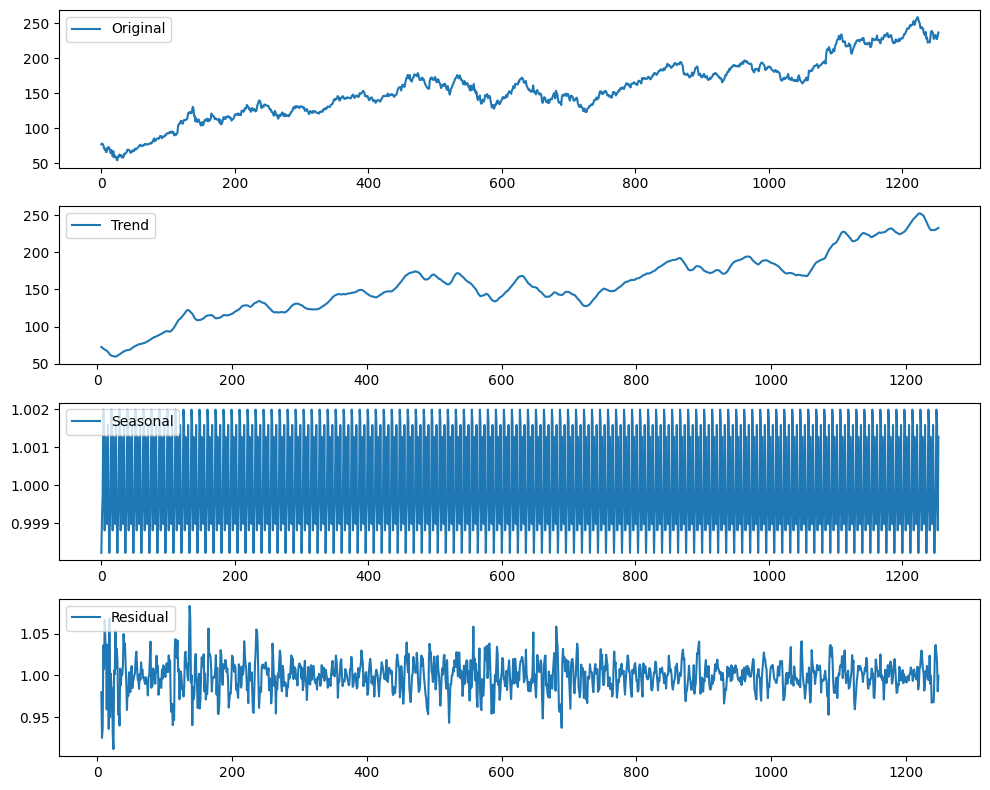

In [5]:
# Perform seasonal decomposition
result = seasonal_decompose(df['Price'], model='multiplicative', period=12)

# Plot the decomposed components
plt.figure(figsize=(10, 8))
plt.subplot(4, 1, 1)
plt.plot(df['Price'], label='Original')
plt.legend(loc='upper left')

plt.subplot(4, 1, 2)
plt.plot(result.trend, label='Trend')
plt.legend(loc='upper left')

plt.subplot(4, 1, 3)
plt.plot(result.seasonal, label='Seasonal')
plt.legend(loc='upper left')

plt.subplot(4, 1, 4)
plt.plot(result.resid, label='Residual')
plt.legend(loc='upper left')

plt.tight_layout()
plt.show()


# Is the Target Variable Autocorrelated?

<Figure size 1000x600 with 0 Axes>

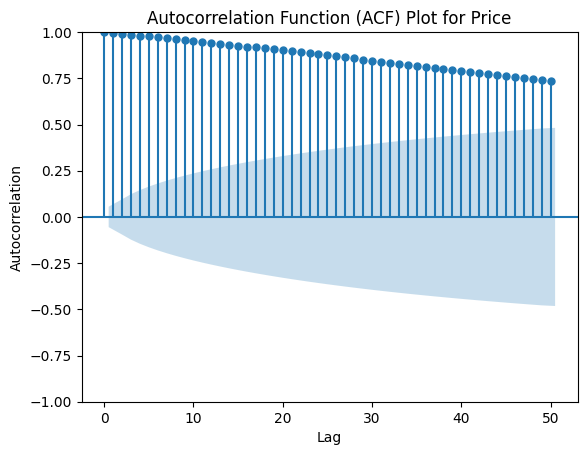

In [6]:
# Plot autocorrelation function (ACF) for the target variable
plt.figure(figsize=(10, 6))
plot_acf(df['Price'], lags=50, alpha=0.05)
plt.xlabel('Lag')
plt.ylabel('Autocorrelation')
plt.title('Autocorrelation Function (ACF) Plot for Price')
plt.show()

# Visualisation

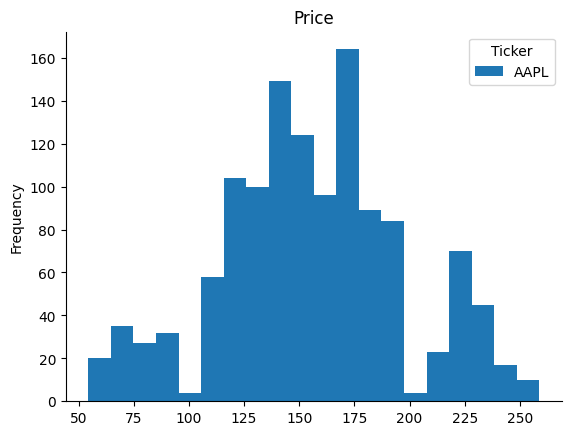

In [7]:
# Plotting a histogram of the 'Price' column in the DataFrame
df['Price'].plot(kind='hist', bins=20, title='Price')

# Removing the top and right spines from the plot
plt.gca().spines[['top', 'right']].set_visible(False)

# Displaying the plot
plt.show()

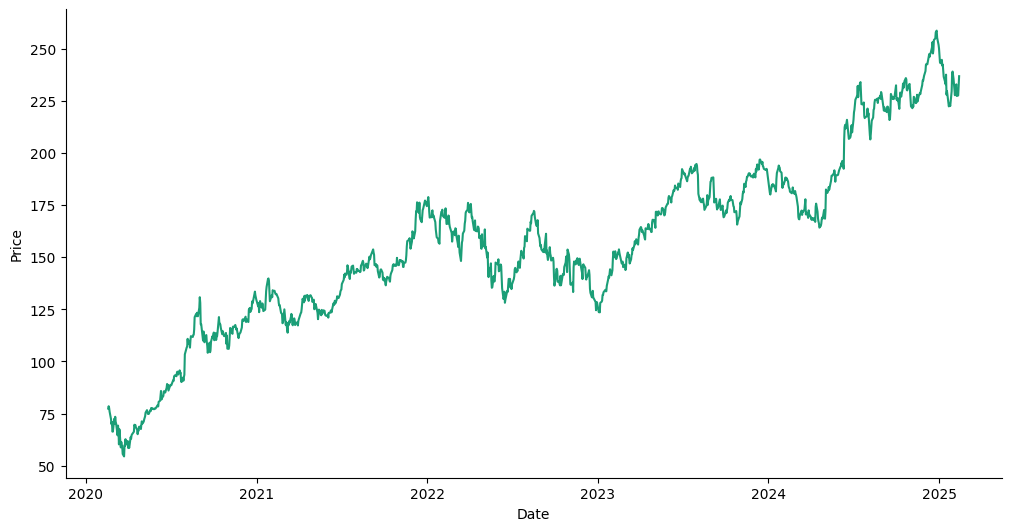

In [8]:
# Plot a Time Series
def _plot_series(series, series_name, series_index=0):
  palette = list(sns.palettes.mpl_palette('Dark2'))
  xs = series['Date']
  ys = series['Price']

  plt.plot(xs, ys, label=series_name, color=palette[series_index % len(palette)])

fig, ax = plt.subplots(figsize=(10, 5.2), layout='constrained')
df_sorted = df.sort_values('Date', ascending=True)
_plot_series(df_sorted, '')
sns.despine(fig=fig, ax=ax)
plt.xlabel('Date')
_ = plt.ylabel('Price')

# Data Preprocessing

In [9]:
# Adding new lagged Features

# Selecting columns 'Date' and 'Price' from the dataframe
data = df[['Date', 'Price']]

# Converting the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

# Importing deepcopy function from the copy module
from copy import deepcopy as dc

# Function to prepare dataframe for LSTM by adding lagged features
def prepare_dataframe_for_lstm(df, n_steps):
    # Creating a deep copy of the dataframe to avoid modifying the original dataframe
    df = dc(df)

    # Setting the 'Date' column as the index
    df.set_index('Date', inplace=True)

    # Adding lagged features by shifting the 'Price' column backward by n_steps
    for i in range(1, n_steps+1):
        df[f'Price(t-{i})'] = df['Price'].shift(i)

    # Dropping rows with NaN values resulting from the shifting operation
    df.dropna(inplace=True)

    return df

# Number of time steps to look back
lookback = 7

# Creating a new dataframe with lagged features
shifted_df = prepare_dataframe_for_lstm(data, lookback)
shifted_df


Price,Price,Price(t-1),Price(t-2),Price(t-3),Price(t-4),Price(t-5),Price(t-6),Price(t-7)
Ticker,AAPL,,,,,,,
Date,,,,,,,,
2020-02-27,66.377563,71.020012,69.910988,72.362030,75.970650,77.730087,78.535782,77.414612
2020-02-28,66.338737,66.377563,71.020012,69.910988,72.362030,75.970650,77.730087,78.535782
2020-03-02,72.514923,66.338737,66.377563,71.020012,69.910988,72.362030,75.970650,77.730087
2020-03-03,70.211899,72.514923,66.338737,66.377563,71.020012,69.910988,72.362030,75.970650
2020-03-04,73.468651,70.211899,72.514923,66.338737,66.377563,71.020012,69.910988,72.362030
...,...,...,...,...,...,...,...,...
2025-02-06,232.963867,232.214691,232.544327,227.759583,235.740814,237.329056,239.097122,237.998322
2025-02-07,227.380005,232.963867,232.214691,232.544327,227.759583,235.740814,237.329056,239.097122


In [10]:
# Converting the DataFrame to a NumPy array
shifted_df_as_np = shifted_df.to_numpy()

# Printing the NumPy array
shifted_df_as_np

array([[ 66.37756348,  71.0200119 ,  69.91098785, ...,  77.73008728,
         78.53578186,  77.41461182],
       [ 66.33873749,  66.37756348,  71.0200119 , ...,  75.97064972,
         77.73008728,  78.53578186],
       [ 72.5149231 ,  66.33873749,  66.37756348, ...,  72.36203003,
         75.97064972,  77.73008728],
       ...,
       [227.6499939 , 227.38000488, 232.96386719, ..., 227.75958252,
        235.74081421, 237.32905579],
       [232.61999512, 227.6499939 , 227.38000488, ..., 232.54432678,
        227.75958252, 235.74081421],
       [236.86999512, 232.61999512, 227.6499939 , ..., 232.21469116,
        232.54432678, 227.75958252]])

In [11]:
# Printing the Numpy array shape
shifted_df_as_np.shape

(1248, 8)

In [12]:
# Importing the MinMaxScaler class from the sklearn.preprocessing module
from sklearn.preprocessing import MinMaxScaler

# Creating an instance of the MinMaxScaler with feature range (-1, 1)
scaler = MinMaxScaler(feature_range=(-1, 1))

# Scaling the NumPy array using the MinMaxScaler
shifted_df_as_np = scaler.fit_transform(shifted_df_as_np)

# Printing the scaled NumPy array
shifted_df_as_np

array([[-0.88322559, -0.83777502, -0.8486326 , ..., -0.77208194,
        -0.76419402, -0.77517051],
       [-0.8836057 , -0.88322559, -0.83777502, ..., -0.78930721,
        -0.77208194, -0.76419402],
       [-0.82313952, -0.8836057 , -0.88322559, ..., -0.82463637,
        -0.78930721, -0.77208194],
       ...,
       [ 0.69566617,  0.69302292,  0.74769013, ...,  0.69673907,
         0.77487704,  0.79042627],
       [ 0.74432355,  0.69566617,  0.69302292, ...,  0.74358274,
         0.69673907,  0.77487704],
       [ 0.78593197,  0.74432355,  0.69566617, ...,  0.74035554,
         0.74358274,  0.69673907]])

In [13]:
# Extracting features (lagged prices) from the scaled NumPy array, excluding the first column which contains the target variable
X = shifted_df_as_np[:, 1:]

# Creating a deep copy of the features array and flipping it along the time axis (axis=1)
X = dc(np.flip(X, axis=1))

# Extracting the target variable (current price) from the scaled NumPy array, which is the first column
y = shifted_df_as_np[:, 0]

# Printing the shapes of the feature matrix (X) and the target array (y)
X.shape, y.shape

((1248, 7), (1248,))

In [14]:
# Calculating the index to split the dataset for validation (50%) and test (70%)
split_val_index = int(len(X) * 0.5)
split_test_index = int(len(X) * 0.7)

# Splitting the feature matrix (X) into training, validation, and test sets
X_train = X[:split_val_index]             # Training set: from the beginning up to the validation split index
X_val = X[split_val_index:split_test_index]    # Validation set: from the validation split index up to the test split index
X_test = X[split_test_index:]             # Test set: from the test split index to the end

# Splitting the target array (y) into training, validation, and test sets using the same indices
y_train = y[:split_val_index]             # Training set: from the beginning up to the validation split index
y_val = y[split_val_index:split_test_index]    # Validation set: from the validation split index up to the test split index
y_test = y[split_test_index:]             # Test set: from the test split index to the end

# Printing the shapes of the training, validation, and test sets
X_train.shape, X_val.shape, X_test.shape, y_train.shape, y_val.shape, y_test.shape

# Create arrays for days corresponding to each dataset
train_days = range(len(X_train))
val_days = range(len(X_train), len(X_train) + len(X_val))
test_days = range(len(X_train) + len(X_val), len(X_train) + len(X_val) + len(X_test))

In [15]:
# Reshaping the training, validation, and test sets to match the input shape expected by the LSTM model
X_train = X_train.reshape((-1, lookback, 1))  # Reshaping X_train to (batch_size, lookback, 1)
X_val = X_val.reshape((-1, lookback, 1))      # Reshaping X_val to (batch_size, lookback, 1)
X_test = X_test.reshape((-1, lookback, 1))    # Reshaping X_test to (batch_size, lookback, 1)

# Reshaping the target arrays to match the output shape expected by the LSTM model
y_train = y_train.reshape((-1, 1))   # Reshaping y_train to (batch_size, 1)
y_val = y_val.reshape((-1, 1))       # Reshaping y_val to (batch_size, 1)
y_test = y_test.reshape((-1, 1))     # Reshaping y_test to (batch_size, 1)

# Printing the shapes of the reshaped datasets
X_train.shape, X_test.shape, y_train.shape, y_test.shape

((624, 7, 1), (375, 7, 1), (624, 1), (375, 1))

In [16]:
# Checking if CUDA (GPU) is available
is_cuda = torch.cuda.is_available()

# If CUDA is available, set the device to GPU; otherwise, set it to CPU
if is_cuda:
    device = torch.device("cuda")  # Setting device to GPU
    print("GPU is available")
else:
    device = torch.device("cpu")   # Setting device to CPU
    print("GPU not available, CPU used")

GPU is available


In [17]:
# Converting the training, validation, and test sets from NumPy arrays to PyTorch tensors and casting to float
X_train = torch.tensor(X_train).float()  # Converting X_train to PyTorch tensor and casting to float
y_train = torch.tensor(y_train).float()  # Converting y_train to PyTorch tensor and casting to float
X_val = torch.tensor(X_val).float()      # Converting X_val to PyTorch tensor and casting to float
y_val = torch.tensor(y_val).float()      # Converting y_val to PyTorch tensor and casting to float
X_test = torch.tensor(X_test).float()    # Converting X_test to PyTorch tensor and casting to float
y_test = torch.tensor(y_test).float()    # Converting y_test to PyTorch tensor and casting to float

# Printing the shapes of the tensors
X_train.shape, X_test.shape, y_train.shape, y_test.shape

(torch.Size([624, 7, 1]),
 torch.Size([375, 7, 1]),
 torch.Size([624, 1]),
 torch.Size([375, 1]))

In [18]:
# Importing the Dataset class from torch.utils.data
from torch.utils.data import Dataset

# Defining a custom dataset class for time series data
class TimeSeriesDataset(Dataset):
    def __init__(self, X, y):
        self.X = X  # Assigning features (X) to the dataset
        self.y = y  # Assigning target values (y) to the dataset

    def __len__(self):
        return len(self.X)  # Returning the length of the dataset (number of samples)

    def __getitem__(self, i):
        return self.X[i], self.y[i]  # Returning a sample (X[i], y[i]) given an index (i)

# Creating instances of the custom dataset class for training, validation, and test sets
train_dataset = TimeSeriesDataset(X_train, y_train)  # Creating a dataset for training data
val_dataset = TimeSeriesDataset(X_val, y_val)      # Creating a dataset for validation data
test_dataset = TimeSeriesDataset(X_test, y_test)    # Creating a dataset for test data

In [19]:
# Importing the DataLoader class from torch.utils.data
from torch.utils.data import DataLoader

# Setting the batch size for data loading
batch_size = 16

# Creating DataLoader instances for training, validation, and test sets
train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)  # DataLoader for training data
val_loader = DataLoader(val_dataset, batch_size=batch_size, shuffle=True)      # DataLoader for validation data
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)    # DataLoader for test data

# Iterating through the training DataLoader to examine a batch
for _, batch in enumerate(train_loader):
    # Extracting features (x_batch) and target values (y_batch) from the batch
    x_batch, y_batch = batch[0].to(device), batch[1].to(device)

    # Printing the shapes of the features and target values in the current batch
    print(x_batch.shape, y_batch.shape)

    # Breaking the loop after printing the shapes of the first batch
    break


torch.Size([16, 7, 1]) torch.Size([16, 1])


In [20]:
# Setting the size of the input features (number of features received at each time step)
input_size = 1  # At each time step, the model receives 1 feature as input

# Setting the size of the hidden state of the LSTM cells
hidden_size = 20  # The number of units in the hidden state of each LSTM cell

# Setting the number of stacked LSTM layers in the model
num_stacked_layers = 2  # The number of LSTM layers stacked on top of each other

# LSTM Model Defining and Training

In [21]:
# Importing the necessary libraries
import torch
import torch.nn as nn

# Defining the LSTM model class
class LSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size  # Assigning the hidden size of the LSTM
        self.num_stacked_layers = num_stacked_layers  # Assigning the number of stacked LSTM layers

        # Defining the LSTM layer
        self.lstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # Defining dropout layer to prevent overfitting
        self.drop = nn.Dropout(0.1)

        # Defining the fully connected layer for output
        self.fc = nn.Linear(hidden_size, 1)  # Output layer to produce the final prediction

    def forward(self, x):
        batch_size = x.size(0)  # Getting the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)  # Initializing the hidden state
        c0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)  # Initializing the cell state

        # Forward pass through the LSTM layer
        out, _ = self.lstm(x, (h0, c0))

        # Passing the output through the fully connected layer
        out = self.fc(out[:, -1, :])  # Taking the last time step's output for each sequence in the batch

        return out

# Creating an instance of the LSTM model
model = LSTM(input_size, hidden_size, num_stacked_layers)

# Moving the model to the specified device (GPU/CPU)
model.to(device)

# Printing the model architecture
model


LSTM(
  (lstm): LSTM(1, 20, num_layers=2, batch_first=True)
  (drop): Dropout(p=0.1, inplace=False)
  (fc): Linear(in_features=20, out_features=1, bias=True)
)

In [22]:
# Initializing lists to store training and validation losses
train_losses, val_losses = [], []

# Initializing the minimum validation loss to a high value
min_val_loss = 100

# Defining the function to train the model for one epoch
def train_one_epoch():
    # Setting the model to training mode
    model.train(True)

    # Printing the current epoch
    print(f'Epoch: {epoch + 1}')

    # Initializing the running loss and correct predictions for the current epoch
    running_loss = 0.0
    correct_predictions = 0
    total_samples = 0

    # Iterating through the batches in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: computing model predictions
        output = model(x_batch)

        # Calculating the loss between model predictions and target labels
        loss = loss_function(output, y_batch)

        # Accumulating the loss
        running_loss += loss.item()

        # Computing the predicted labels
        _, predicted = torch.max(output, 1)

        # Counting the number of correct predictions
        correct_predictions += (predicted == y_batch).sum().item()

        # Counting total samples
        total_samples += y_batch.size(0)

        # Zeroing the gradients
        optimizer.zero_grad()

        # Backward pass: computing gradients
        loss.backward()

        # Updating model parameters
        optimizer.step()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(train_loader)


    # Appending the average training loss and accuracy to the respective lists
    train_losses.append(avg_loss_across_batches)

    # Printing the average training loss and accuracy for the current epoch
    print('Average train loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

Epoch: 1
Average train loss: 0.140

Average valid loss: 0.058560
Saving model...
---------------------------------------------------------------------------

Epoch: 2
Average train loss: 0.077

Average valid loss: 0.106637
---------------------------------------------------------------------------

Epoch: 3
Average train loss: 0.057

Average valid loss: 0.084879
---------------------------------------------------------------------------

Epoch: 4
Average train loss: 0.025

Average valid loss: 0.028733
Saving model...
---------------------------------------------------------------------------

Epoch: 5
Average train loss: 0.005

Average valid loss: 0.012534
Saving model...
---------------------------------------------------------------------------

Epoch: 6
Average train loss: 0.004

Average valid loss: 0.010921
Saving model...
---------------------------------------------------------------------------

Epoch: 7
Average train loss: 0.003

Average valid loss: 0.007824
Saving model...
---

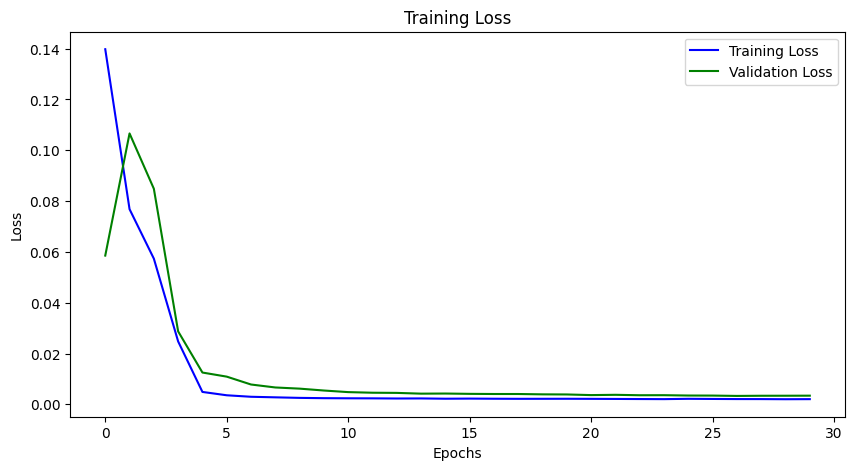

In [23]:
# Function to validate the model on the validation set for one epoch
def validate_one_epoch(loader, min_val_loss):
    # Setting the model to evaluation mode (no training)
    model.train(False)
    running_loss = 0.0

    # Iterating through the batches in the loader
    for batch_index, batch in enumerate(loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disabling gradient computation for validation
        with torch.no_grad():
            # Forward pass: computing model predictions
            output = model(x_batch)

            # Calculating the loss between predictions and target labels
            loss = loss_function(output, y_batch)

            # Accumulating the loss
            running_loss += loss.item()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(loader)

    # Printing the average validation loss for the current epoch
    print('Average valid loss: {0:.6f}'.format(avg_loss_across_batches))

    # Appending the average validation loss to the list of validation losses
    val_losses.append(avg_loss_across_batches)

    # If the current validation loss is lower than the minimum validation loss so far
    if (avg_loss_across_batches < min_val_loss):
        # Update the minimum validation loss
        min_val_loss = avg_loss_across_batches

        # Save the model parameters
        torch.save(model.state_dict(), '/content/LSTM_model_timeSeries.ckpt')
        print('Saving model...')

    # Printing a separator line for clarity
    print(25 * '---')
    print()

    # Returning the updated minimum validation loss
    return min_val_loss

test_losses = []
# Function to test the model on the test set for one epoch
def test_one_epoch(loader):
    # Setting the model to evaluation mode (no training)
    model.train(False)
    running_loss = 0.0

    # Iterating through the batches in the loader
    for batch_index, batch in enumerate(loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disabling gradient computation for testing
        with torch.no_grad():
            # Forward pass: computing model predictions
            output = model(x_batch)

            # Calculating the loss between predictions and target labels
            loss = loss_function(output, y_batch)

            # Accumulating the loss
            running_loss += loss.item()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(loader)

    # Printing the average loss on the test set
    print('Loss: {0:.6f}'.format(avg_loss_across_batches))

    # Printing a separator line for clarity
    print(25 * '---')
    print()

# Hyperparameters and optimizer configuration
lr = 5e-4
num_epochs = 30
loss_function = nn.MSELoss()
weight_decay = 1e-4
optimizer = torch.optim.Adam(model.parameters(), lr=lr, weight_decay=weight_decay)

# Initializing the minimum validation loss to a high value
min_val_loss = float('inf')

# Training loop over epochs
for epoch in range(num_epochs):
    # Training the model for one epoch
    train_one_epoch()

    # Validating the model on the validation set for one epoch
    min_val_loss = validate_one_epoch(val_loader, min_val_loss)

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()



In [24]:
# Using torch.no_grad() to temporarily disable gradient calculation, as we're only evaluating the model here
with torch.no_grad():
    # Printing the Mean Squared Error (MSE) loss on the training set
    print('MSELoss on train set')

    # Getting model predictions on the training set and converting them to numpy array on CPU
    train_predictions = model(X_train.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the training set
    test_one_epoch(train_loader)

    # Printing the Mean Squared Error (MSE) loss on the validation set
    print('MSELoss on validation set')

    # Getting model predictions on the validation set and converting them to numpy array on CPU
    val_predictions = model(X_val.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the validation set
    test_one_epoch(val_loader)

    # Printing the Mean Squared Error (MSE) loss on the test set
    print('MSELoss on test set')

    # Getting model predictions on the test set and converting them to numpy array on CPU
    test_predictions = model(X_test.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the test set
    test_one_epoch(test_loader)

MSELoss on train set
Loss: 0.002010
---------------------------------------------------------------------------

MSELoss on validation set
Loss: 0.003480
---------------------------------------------------------------------------

MSELoss on test set
Loss: 0.059932
---------------------------------------------------------------------------



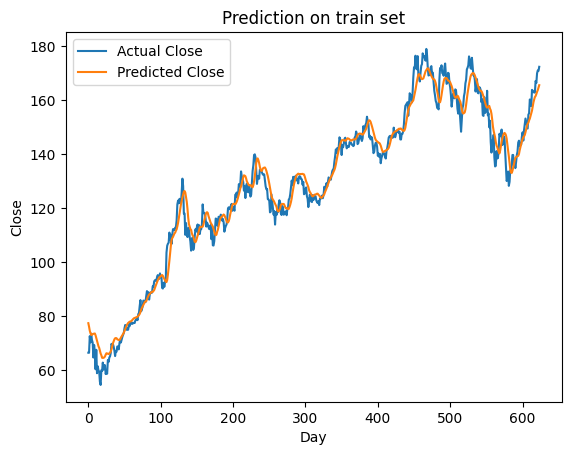

In [25]:
# Flattening the train_predictions array
train_predictions =  train_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
train_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_train = dc(dummies[:, 0])

# Flattening the val_predictions array
val_predictions = val_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
val_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_val = dc(dummies[:, 0])

# Flattening the test_predictions array
test_predictions = test_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
test_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_test = dc(dummies[:, 0])

# Plotting the actual and predicted values for the training set
plt.plot(train_days, new_y_train, label='Actual Close')
plt.plot(train_days, train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on train set')
plt.legend()
plt.show()

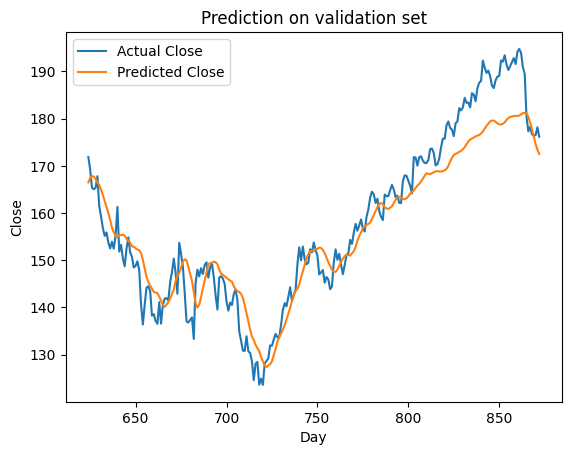

In [26]:
# Plotting the actual and predicted values for the validation set
plt.plot(val_days, new_y_val, label='Actual Close')
plt.plot(val_days, val_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on validation set')
plt.legend()
plt.show()

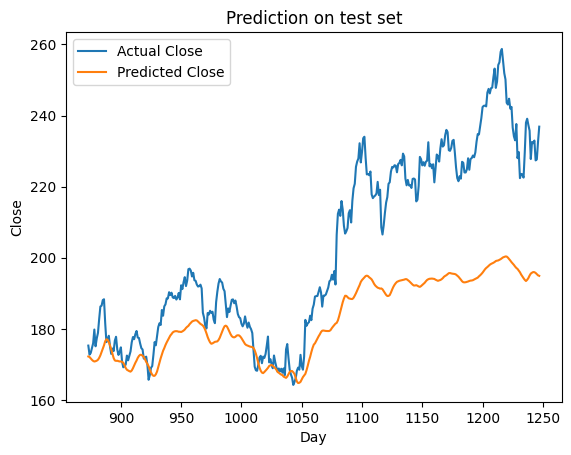

In [27]:
# Plotting the actual and predicted values for the test set
plt.plot(test_days, new_y_test, label='Actual Close')
plt.plot(test_days, test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on test set')
plt.legend()
plt.show()

# BILSTM

Epoch: 1
Average train loss: 0.153

Average valid loss: 0.052366
Saving model...
---------------------------------------------------------------------------

Epoch: 2
Average train loss: 0.071

Average valid loss: 0.099060
---------------------------------------------------------------------------

Epoch: 3
Average train loss: 0.043

Average valid loss: 0.045273
Saving model...
---------------------------------------------------------------------------

Epoch: 4
Average train loss: 0.011

Average valid loss: 0.011576
Saving model...
---------------------------------------------------------------------------

Epoch: 5
Average train loss: 0.003

Average valid loss: 0.009467
Saving model...
---------------------------------------------------------------------------

Epoch: 6
Average train loss: 0.002

Average valid loss: 0.007324
Saving model...
---------------------------------------------------------------------------

Epoch: 7
Average train loss: 0.002

Average valid loss: 0.005917
Sav

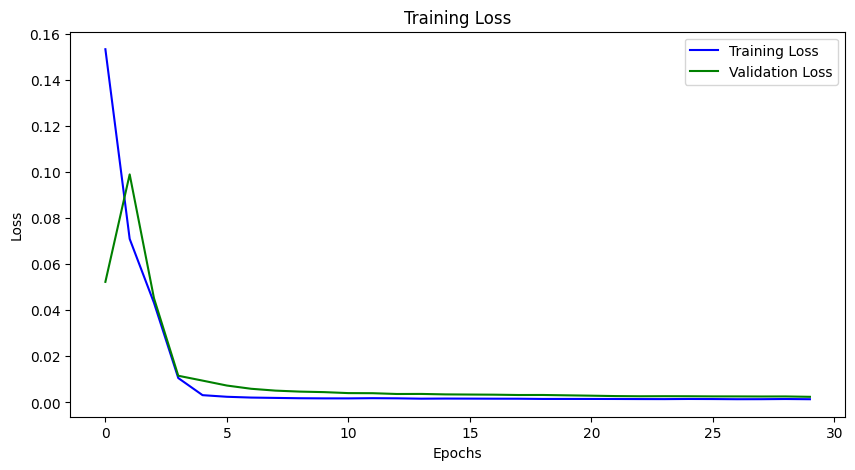

MSELoss on train set
Loss: 0.002010
---------------------------------------------------------------------------

MSELoss on validation set
Loss: 0.003378
---------------------------------------------------------------------------

MSELoss on test set
Loss: 0.059932
---------------------------------------------------------------------------



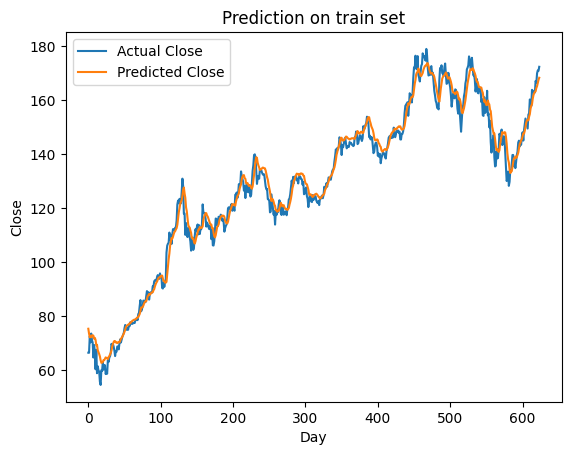

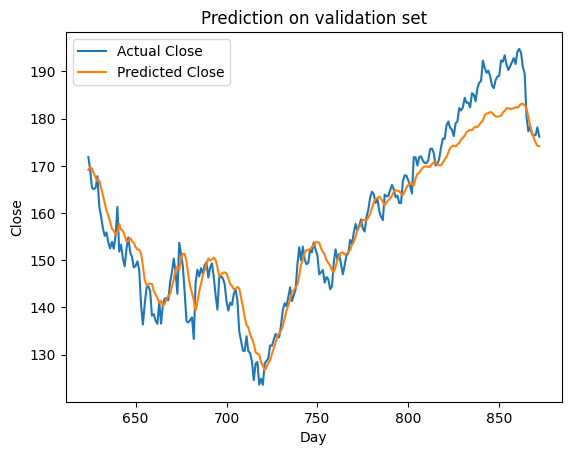

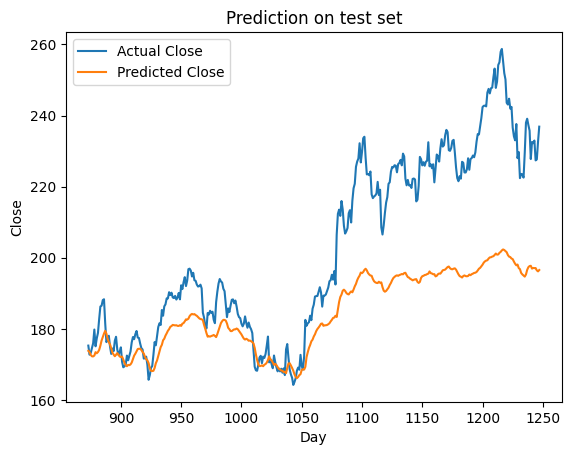

In [28]:
# Importing necessary libraries
import torch
import torch.nn as nn

# Defining the BiLSTM model class
class BiLSTM(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size  # Assigning the hidden size of the BiLSTM
        self.num_stacked_layers = num_stacked_layers  # Assigning the number of stacked BiLSTM layers

        # Defining the BiLSTM layer
        self.bilstm = nn.LSTM(input_size, hidden_size, num_stacked_layers, batch_first=True, bidirectional=True)

        # Defining dropout layer to prevent overfitting
        self.drop = nn.Dropout(0.1)

        # Defining the fully connected layer for output
        self.fc = nn.Linear(hidden_size * 2, 1)  # Output layer to produce the final prediction (multiplying by 2 for bidirectional LSTM)

    def forward(self, x):
        batch_size = x.size(0)  # Getting the batch size
        h0 = torch.zeros(self.num_stacked_layers * 2, batch_size, self.hidden_size).to(device)  # Initializing the hidden state
        c0 = torch.zeros(self.num_stacked_layers * 2, batch_size, self.hidden_size).to(device)  # Initializing the cell state

        # Forward pass through the BiLSTM layer
        out, _ = self.bilstm(x, (h0, c0))

        # Passing the output through the fully connected layer
        out = self.fc(out[:, -1, :])  # Taking the last time step's output for each sequence in the batch

        return out

# Creating an instance of the BiLSTM model
bi_lstm_model = BiLSTM(input_size, hidden_size, num_stacked_layers)

# Moving the model to the specified device (GPU/CPU)
bi_lstm_model.to(device)

# Printing the model architecture
bi_lstm_model


# Initializing lists to store training and validation losses
train_losses, val_losses = [], []

# Initializing the minimum validation loss to a high value
min_val_loss = 100

# Defining the function to train the model for one epoch
def train_one_epoch(model, train_loader, optimizer, loss_function, epoch):
    # Setting the model to training mode
    model.train(True)

    # Printing the current epoch
    print(f'Epoch: {epoch + 1}')

    # Initializing the running loss for the current epoch
    running_loss = 0.0

    # Iterating through the batches in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: computing model predictions
        output = model(x_batch)

        # Calculating the loss between model predictions and target labels
        loss = loss_function(output, y_batch)

        # Accumulating the loss
        running_loss += loss.item()

        # Zeroing the gradients
        optimizer.zero_grad()

        # Backward pass: computing gradients
        loss.backward()

        # Updating model parameters
        optimizer.step()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(train_loader)

    # Appending the average training loss to the list of training losses
    train_losses.append(avg_loss_across_batches)

    # Printing the average training loss for the current epoch
    print('Average train loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

# Function to validate the model on the validation set for one epoch
def validate_one_epoch(model, val_loader, min_val_loss, loss_function):
    # Setting the model to evaluation mode (no training)
    model.train(False)
    running_loss = 0.0

    # Iterating through the batches in the loader
    for batch_index, batch in enumerate(val_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disabling gradient computation for validation
        with torch.no_grad():
            # Forward pass: computing model predictions
            output = model(x_batch)

            # Calculating the loss between predictions and target labels
            loss = loss_function(output, y_batch)

            # Accumulating the loss
            running_loss += loss.item()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(val_loader)

    # Printing the average validation loss for the current epoch
    print('Average valid loss: {0:.6f}'.format(avg_loss_across_batches))

    # Appending the average validation loss to the list of validation losses
    val_losses.append(avg_loss_across_batches)

    # If the current validation loss is lower than the minimum validation loss so far
    if (avg_loss_across_batches < min_val_loss):
        # Update the minimum validation loss
        min_val_loss = avg_loss_across_batches

        # Save the model parameters
        torch.save(model.state_dict(), '/content/BiLSTM_model_timeSeries.ckpt')
        print('Saving model...')

    # Printing a separator line for clarity
    print(25 * '---')
    print()

    # Returning the updated minimum validation loss
    return min_val_loss

# Hyperparameters and optimizer configuration
lr = 5e-4
num_epochs = 30
loss_function = nn.MSELoss()
weight_decay = 1e-4
optimizer = torch.optim.Adam(bi_lstm_model.parameters(), lr=lr, weight_decay=weight_decay)

# Initializing the minimum validation loss to a high value
min_val_loss = float('inf')

# Training loop over epochs
for epoch in range(num_epochs):
    # Training the model for one epoch
    train_one_epoch(bi_lstm_model, train_loader, optimizer, loss_function, epoch)

    # Validating the model on the validation set for one epoch
    min_val_loss = validate_one_epoch(bi_lstm_model, val_loader, min_val_loss, loss_function)

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()



# Using torch.no_grad() to temporarily disable gradient calculation, as we're only evaluating the model here
with torch.no_grad():
    # Printing the Mean Squared Error (MSE) loss on the training set
    print('MSELoss on train set')

    # Getting model predictions on the training set and converting them to numpy array on CPU
    train_predictions = bi_lstm_model(X_train.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the training set
    test_one_epoch(train_loader)

    # Printing the Mean Squared Error (MSE) loss on the validation set
    print('MSELoss on validation set')

    # Getting model predictions on the validation set and converting them to numpy array on CPU
    val_predictions = bi_lstm_model(X_val.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the validation set
    test_one_epoch(val_loader)

    # Printing the Mean Squared Error (MSE) loss on the test set
    print('MSELoss on test set')

    # Getting model predictions on the test set and converting them to numpy array on CPU
    test_predictions = bi_lstm_model(X_test.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the test set
    test_one_epoch(test_loader)

# Flattening the train_predictions array
train_predictions =  train_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
train_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_train = dc(dummies[:, 0])

# Flattening the val_predictions array
val_predictions = val_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
val_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_val = dc(dummies[:, 0])

# Flattening the test_predictions array
test_predictions = test_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
test_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_test = dc(dummies[:, 0])

# Plotting the actual and predicted values for the training set
plt.plot(train_days, new_y_train, label='Actual Close')
plt.plot(train_days, train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on train set')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the validation set
plt.plot(val_days, new_y_val, label='Actual Close')
plt.plot(val_days, val_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on validation set')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the test set
plt.plot(test_days, new_y_test, label='Actual Close')
plt.plot(test_days, test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on test set')
plt.legend()
plt.show()

# RNN

Epoch: 1
Average train loss: 0.099

Average valid loss: 0.081559
Saving model...
---------------------------------------------------------------------------

Epoch: 2
Average train loss: 0.038

Average valid loss: 0.013013
Saving model...
---------------------------------------------------------------------------

Epoch: 3
Average train loss: 0.006

Average valid loss: 0.003916
Saving model...
---------------------------------------------------------------------------

Epoch: 4
Average train loss: 0.003

Average valid loss: 0.002232
Saving model...
---------------------------------------------------------------------------

Epoch: 5
Average train loss: 0.002

Average valid loss: 0.001801
Saving model...
---------------------------------------------------------------------------

Epoch: 6
Average train loss: 0.002

Average valid loss: 0.002283
---------------------------------------------------------------------------

Epoch: 7
Average train loss: 0.002

Average valid loss: 0.001742
Sav

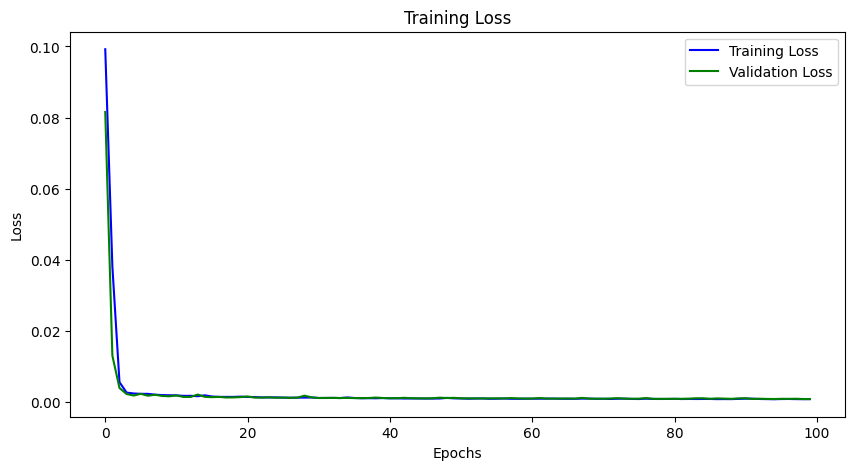

MSELoss on train set
Loss: 0.002010
---------------------------------------------------------------------------

MSELoss on validation set
Loss: 0.003407
---------------------------------------------------------------------------

MSELoss on test set
Loss: 0.059932
---------------------------------------------------------------------------



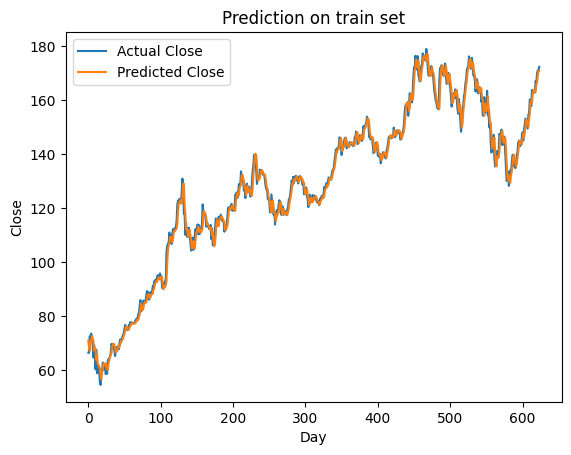

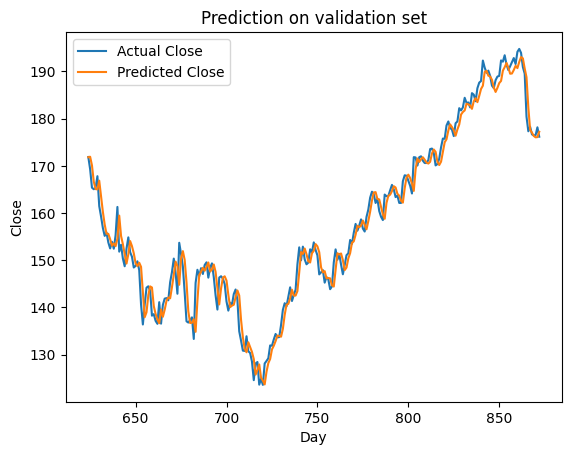

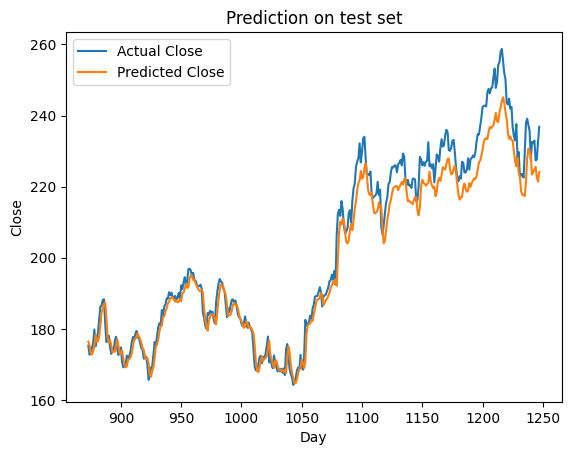

In [29]:
# Importing necessary libraries
import torch
import torch.nn as nn

# Defining the RNN model class
class SimpleRNN(nn.Module):
    def __init__(self, input_size, hidden_size, num_stacked_layers):
        super().__init__()
        self.hidden_size = hidden_size  # Assigning the hidden size of the RNN
        self.num_stacked_layers = num_stacked_layers  # Assigning the number of stacked RNN layers

        # Defining the RNN layer
        self.rnn = nn.RNN(input_size, hidden_size, num_stacked_layers, batch_first=True)

        # Defining dropout layer to prevent overfitting
        self.drop = nn.Dropout(0.1)

        # Defining the fully connected layer for output
        self.fc = nn.Linear(hidden_size, 1)  # Output layer to produce the final prediction

    def forward(self, x):
        batch_size = x.size(0)  # Getting the batch size
        h0 = torch.zeros(self.num_stacked_layers, batch_size, self.hidden_size).to(device)  # Initializing the hidden state

        # Forward pass through the RNN layer
        out, _ = self.rnn(x, h0)

        # Passing the output through the fully connected layer
        out = self.fc(out[:, -1, :])  # Taking the last time step's output for each sequence in the batch

        return out

# Creating an instance of the SimpleRNN model
rnn_model = SimpleRNN(input_size, hidden_size, num_stacked_layers)

# Moving the model to the specified device (GPU/CPU)
rnn_model.to(device)

# Printing the model architecture
rnn_model


# Initializing lists to store training and validation losses
train_losses, val_losses = [], []

# Initializing the minimum validation loss to a high value
min_val_loss = 100

# Defining the function to train the model for one epoch
def train_one_epoch(model, train_loader, optimizer, loss_function, epoch):
    # Setting the model to training mode
    model.train(True)

    # Printing the current epoch
    print(f'Epoch: {epoch + 1}')

    # Initializing the running loss for the current epoch
    running_loss = 0.0

    # Iterating through the batches in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: computing model predictions
        output = model(x_batch)

        # Calculating the loss between model predictions and target labels
        loss = loss_function(output, y_batch)

        # Accumulating the loss
        running_loss += loss.item()

        # Zeroing the gradients
        optimizer.zero_grad()

        # Backward pass: computing gradients
        loss.backward()

        # Updating model parameters
        optimizer.step()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(train_loader)

    # Appending the average training loss to the list of training losses
    train_losses.append(avg_loss_across_batches)

    # Printing the average training loss for the current epoch
    print('Average train loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

# Function to validate the model on the validation set for one epoch
def validate_one_epoch(model, val_loader, min_val_loss, loss_function):
    # Setting the model to evaluation mode (no training)
    model.train(False)
    running_loss = 0.0

    # Iterating through the batches in the loader
    for batch_index, batch in enumerate(val_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disabling gradient computation for validation
        with torch.no_grad():
            # Forward pass: computing model predictions
            output = model(x_batch)

            # Calculating the loss between predictions and target labels
            loss = loss_function(output, y_batch)

            # Accumulating the loss
            running_loss += loss.item()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(val_loader)

    # Printing the average validation loss for the current epoch
    print('Average valid loss: {0:.6f}'.format(avg_loss_across_batches))

    # Appending the average validation loss to the list of validation losses
    val_losses.append(avg_loss_across_batches)

    # If the current validation loss is lower than the minimum validation loss so far
    if (avg_loss_across_batches < min_val_loss):
        # Update the minimum validation loss
        min_val_loss = avg_loss_across_batches

        # Save the model parameters
        torch.save(model.state_dict(), '/content/RNN_model_timeSeries.ckpt')
        print('Saving model...')

    # Printing a separator line for clarity
    print(25 * '---')
    print()

    # Returning the updated minimum validation loss
    return min_val_loss

# Hyperparameters and optimizer configuration
lr = 5e-4
num_epochs = 100
loss_function = nn.MSELoss()
weight_decay = 1e-4
optimizer = torch.optim.Adam(rnn_model.parameters(), lr=lr, weight_decay=weight_decay)

# Initializing the minimum validation loss to a high value
min_val_loss = float('inf')

# Training loop over epochs
for epoch in range(num_epochs):
    # Training the model for one epoch
    train_one_epoch(rnn_model, train_loader, optimizer, loss_function, epoch)

    # Validating the model on the validation set for one epoch
    min_val_loss = validate_one_epoch(rnn_model, val_loader, min_val_loss, loss_function)

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


# Using torch.no_grad() to temporarily disable gradient calculation, as we're only evaluating the model here
with torch.no_grad():
    # Printing the Mean Squared Error (MSE) loss on the training set
    print('MSELoss on train set')

    # Getting model predictions on the training set and converting them to numpy array on CPU
    train_predictions = rnn_model(X_train.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the training set
    test_one_epoch(train_loader)

    # Printing the Mean Squared Error (MSE) loss on the validation set
    print('MSELoss on validation set')

    # Getting model predictions on the validation set and converting them to numpy array on CPU
    val_predictions = rnn_model(X_val.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the validation set
    test_one_epoch(val_loader)

    # Printing the Mean Squared Error (MSE) loss on the test set
    print('MSELoss on test set')

    # Getting model predictions on the test set and converting them to numpy array on CPU
    test_predictions = rnn_model(X_test.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the test set
    test_one_epoch(test_loader)

# Flattening the train_predictions array
train_predictions =  train_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
train_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_train = dc(dummies[:, 0])

# Flattening the val_predictions array
val_predictions = val_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
val_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_val = dc(dummies[:, 0])

# Flattening the test_predictions array
test_predictions = test_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
test_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_test = dc(dummies[:, 0])

# Plotting the actual and predicted values for the training set
plt.plot(train_days, new_y_train, label='Actual Close')
plt.plot(train_days, train_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on train set')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the validation set
plt.plot(val_days, new_y_val, label='Actual Close')
plt.plot(val_days, val_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on validation set')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the test set
plt.plot(test_days, new_y_test, label='Actual Close')
plt.plot(test_days, test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on test set')
plt.legend()
plt.show()


# Ensemble Model

Epoch: 1
Average train loss: 0.161

Average valid loss: 0.012677
Saving model...
---------------------------------------------------------------------------

Epoch: 2
Average train loss: 0.161

Average valid loss: 0.013453
---------------------------------------------------------------------------

Epoch: 3
Average train loss: 0.161

Average valid loss: 0.013323
---------------------------------------------------------------------------

Epoch: 4
Average train loss: 0.161

Average valid loss: 0.012855
---------------------------------------------------------------------------

Epoch: 5
Average train loss: 0.161

Average valid loss: 0.014670
---------------------------------------------------------------------------

Epoch: 6
Average train loss: 0.161

Average valid loss: 0.012701
---------------------------------------------------------------------------

Epoch: 7
Average train loss: 0.161

Average valid loss: 0.013115
-------------------------------------------------------------------

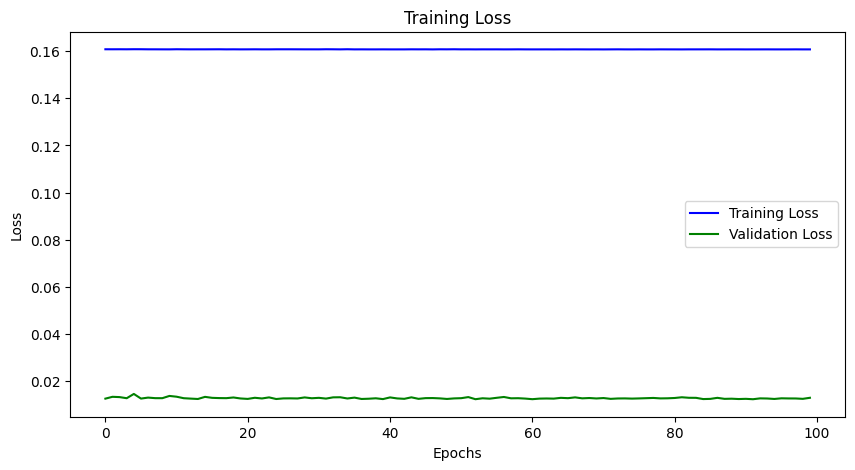

MSELoss on train set
Loss: 0.002010
---------------------------------------------------------------------------

MSELoss on validation set
Loss: 0.003456
---------------------------------------------------------------------------

MSELoss on test set
Loss: 0.059932
---------------------------------------------------------------------------



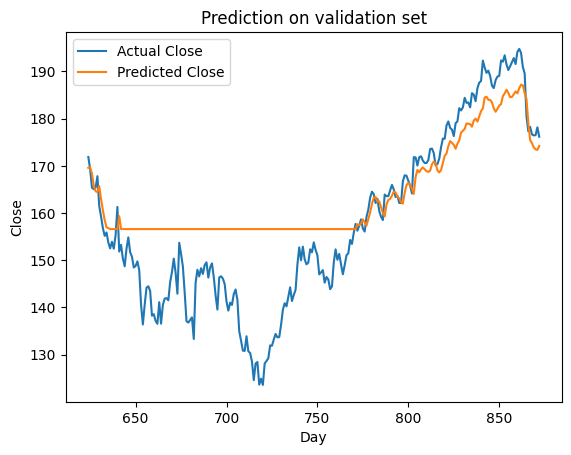

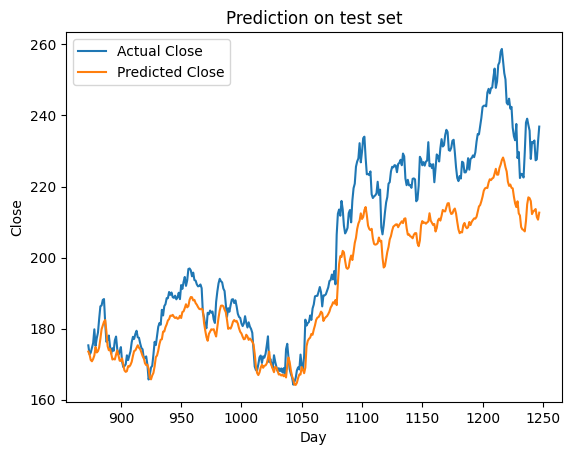

In [30]:
# Ensemble With RNN and BiLSTM
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the EnsembleModel class
class EnsembleModel(nn.Module):
    def __init__(self, bilstm_model, rnn_model):
        super().__init__()
        self.rnn_model = rnn_model
        # self.lstm_model = lstm_model
        self.bilstm_model = bilstm_model

    def forward(self, x):
        # lstm_output = self.lstm_model(x)
        rnn_output = self.rnn_model(x)
        bilstm_output = self.bilstm_model(x)


        # Combine outputs by averaging
        combined_output = ( bilstm_output + rnn_output) / 2

        # Apply activation function if needed
        combined_output = F.relu(combined_output)

        return combined_output



# Creating an instance of the EnsembleModel
ensemble_model = EnsembleModel( rnn_model,bi_lstm_model )

# Moving the model to the specified device (GPU/CPU)
ensemble_model.to(device)

# Initializing lists to store training and validation losses
train_losses, val_losses = [], []

# Initializing the minimum validation loss to a high value
min_val_loss = 100

# Defining the function to train the model for one epoch
def train_one_epoch(model, train_loader, optimizer, loss_function, epoch):
    # Setting the model to training mode
    model.train(True)

    # Printing the current epoch
    print(f'Epoch: {epoch + 1}')

    # Initializing the running loss for the current epoch
    running_loss = 0.0

    # Iterating through the batches in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: computing model predictions
        output = model(x_batch)

        # Calculating the loss between model predictions and target labels
        loss = loss_function(output, y_batch)

        # Accumulating the loss
        running_loss += loss.item()

        # Zeroing the gradients
        optimizer.zero_grad()

        # Backward pass: computing gradients
        loss.backward()

        # Updating model parameters
        optimizer.step()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(train_loader)

    # Appending the average training loss to the list of training losses
    train_losses.append(avg_loss_across_batches)

    # Printing the average training loss for the current epoch
    print('Average train loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

# Function to validate the model on the validation set for one epoch
def validate_one_epoch(model, val_loader, min_val_loss, loss_function):
    # Setting the model to evaluation mode (no training)
    model.train(False)
    running_loss = 0.0

    # Iterating through the batches in the loader
    for batch_index, batch in enumerate(val_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disabling gradient computation for validation
        with torch.no_grad():
            # Forward pass: computing model predictions
            output = model(x_batch)

            # Calculating the loss between predictions and target labels
            loss = loss_function(output, y_batch)

            # Accumulating the loss
            running_loss += loss.item()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(val_loader)

    # Printing the average validation loss for the current epoch
    print('Average valid loss: {0:.6f}'.format(avg_loss_across_batches))

    # Appending the average validation loss to the list of validation losses
    val_losses.append(avg_loss_across_batches)

    # If the current validation loss is lower than the minimum validation loss so far
    if (avg_loss_across_batches < min_val_loss):
        # Update the minimum validation loss
        min_val_loss = avg_loss_across_batches

        # Save the model parameters
        torch.save(model.state_dict(), '/content/Ensemble_model_timeSeries.ckpt')
        print('Saving model...')

    # Printing a separator line for clarity
    print(25 * '---')
    print()

    # Returning the updated minimum validation loss
    return min_val_loss

# Hyperparameters and optimizer configuration
lr = 5e-4
num_epochs = 100
loss_function = nn.MSELoss()
weight_decay = 1e-4
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=lr, weight_decay=weight_decay)

# Initializing the minimum validation loss to a high value
min_val_loss = float('inf')

# Training loop over epochs
for epoch in range(num_epochs):
    # Training the model for one epoch
    train_one_epoch(ensemble_model, train_loader, optimizer, loss_function, epoch)

    # Validating the model on the validation set for one epoch
    min_val_loss = validate_one_epoch(ensemble_model, val_loader, min_val_loss, loss_function)

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


# Using torch.no_grad() to temporarily disable gradient calculation, as we're only evaluating the model here
with torch.no_grad():
    # Printing the Mean Squared Error (MSE) loss on the training set
    print('MSELoss on train set')

    # Getting model predictions on the training set and converting them to numpy array on CPU
    train_predictions = ensemble_model(X_train.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the training set
    test_one_epoch(train_loader)

    # Printing the Mean Squared Error (MSE) loss on the validation set
    print('MSELoss on validation set')

    # Getting model predictions on the validation set and converting them to numpy array on CPU
    val_predictions = ensemble_model(X_val.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the validation set
    test_one_epoch(val_loader)

    # Printing the Mean Squared Error (MSE) loss on the test set
    print('MSELoss on test set')

    # Getting model predictions on the test set and converting them to numpy array on CPU
    test_predictions = ensemble_model(X_test.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the test set
    test_one_epoch(test_loader)

# Flattening the train_predictions array
train_predictions = train_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
train_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_train = dc(dummies[:, 0])

# Flattening the val_predictions array
val_predictions = val_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
val_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_val = dc(dummies[:, 0])

# Flattening the test_predictions array
test_predictions = test_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
test_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_test = dc(dummies[:, 0])




# Plotting the actual and predicted values for the validation set
plt.plot(val_days, new_y_val, label='Actual Close')
plt.plot(val_days, val_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on validation set')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the test set
plt.plot(test_days, new_y_test, label='Actual Close')
plt.plot(test_days, test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on test set')
plt.legend()
plt.show()


Epoch: 1
Average train loss: 0.161

Average valid loss: 0.016524
Saving model...
---------------------------------------------------------------------------

Epoch: 2
Average train loss: 0.161

Average valid loss: 0.015644
Saving model...
---------------------------------------------------------------------------

Epoch: 3
Average train loss: 0.161

Average valid loss: 0.015655
---------------------------------------------------------------------------

Epoch: 4
Average train loss: 0.161

Average valid loss: 0.015740
---------------------------------------------------------------------------

Epoch: 5
Average train loss: 0.161

Average valid loss: 0.014913
Saving model...
---------------------------------------------------------------------------

Epoch: 6
Average train loss: 0.161

Average valid loss: 0.014836
Saving model...
---------------------------------------------------------------------------

Epoch: 7
Average train loss: 0.161

Average valid loss: 0.014947
-------------------

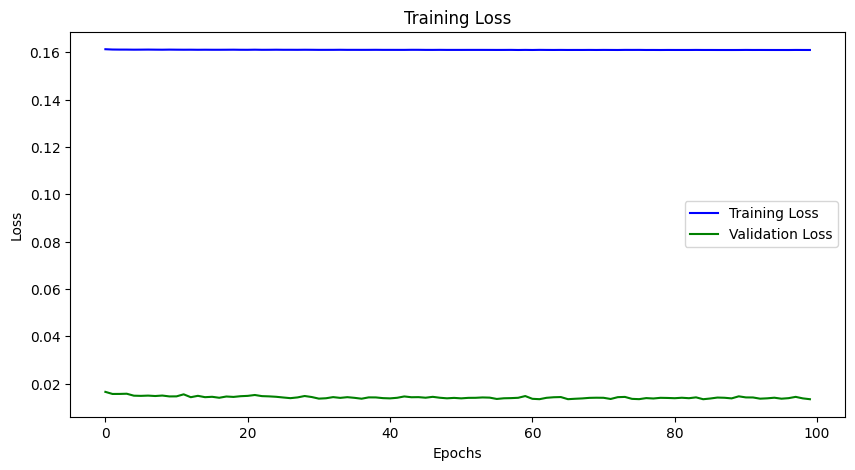

MSELoss on train set
Loss: 0.006626
---------------------------------------------------------------------------

MSELoss on validation set
Loss: 0.005001
---------------------------------------------------------------------------

MSELoss on test set
Loss: 0.005478
---------------------------------------------------------------------------



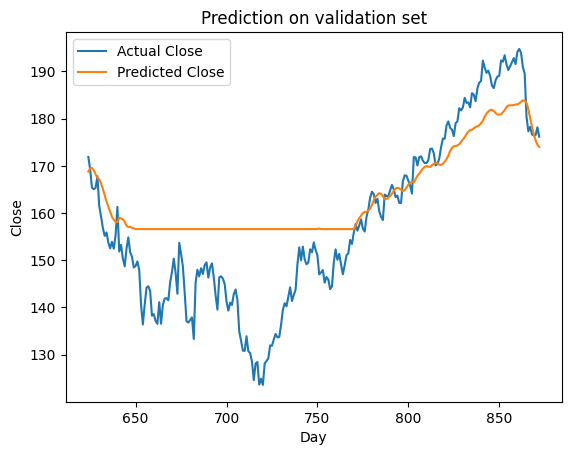

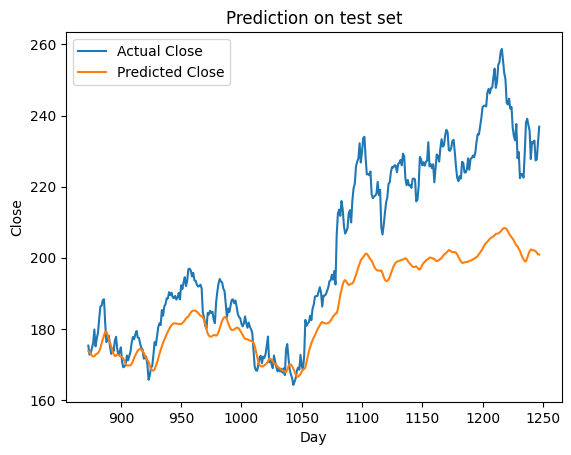

In [31]:
# Ensemble With LSTM and BiLSTM
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the EnsembleModel class
class EnsembleModel(nn.Module):
    def __init__(self, model, bilstm_model ):
        super().__init__()
        # self.rnn_model = rnn_model
        self.lstm_model = model
        self.bilstm_model = bilstm_model

    def forward(self, x):
        lstm_output = self.lstm_model(x)
        # rnn_output = self.rnn_model(x)
        bilstm_output = self.bilstm_model(x)


        # Combine outputs by averaging
        combined_output = ( bilstm_output + lstm_output) / 2

        # Apply activation function if needed
        combined_output = F.relu(combined_output)

        return combined_output



# Creating an instance of the EnsembleModel
ensemble_model = EnsembleModel( model,bi_lstm_model )

# Moving the model to the specified device (GPU/CPU)
ensemble_model.to(device)

# Initializing lists to store training and validation losses
train_losses, val_losses = [], []

# Initializing the minimum validation loss to a high value
min_val_loss = 100

# Defining the function to train the model for one epoch
def train_one_epoch(model, train_loader, optimizer, loss_function, epoch):
    # Setting the model to training mode
    model.train(True)

    # Printing the current epoch
    print(f'Epoch: {epoch + 1}')

    # Initializing the running loss for the current epoch
    running_loss = 0.0

    # Iterating through the batches in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: computing model predictions
        output = model(x_batch)

        # Calculating the loss between model predictions and target labels
        loss = loss_function(output, y_batch)

        # Accumulating the loss
        running_loss += loss.item()

        # Zeroing the gradients
        optimizer.zero_grad()

        # Backward pass: computing gradients
        loss.backward()

        # Updating model parameters
        optimizer.step()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(train_loader)

    # Appending the average training loss to the list of training losses
    train_losses.append(avg_loss_across_batches)

    # Printing the average training loss for the current epoch
    print('Average train loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

# Function to validate the model on the validation set for one epoch
def validate_one_epoch(model, val_loader, min_val_loss, loss_function):
    # Setting the model to evaluation mode (no training)
    model.train(False)
    running_loss = 0.0

    # Iterating through the batches in the loader
    for batch_index, batch in enumerate(val_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disabling gradient computation for validation
        with torch.no_grad():
            # Forward pass: computing model predictions
            output = model(x_batch)

            # Calculating the loss between predictions and target labels
            loss = loss_function(output, y_batch)

            # Accumulating the loss
            running_loss += loss.item()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(val_loader)

    # Printing the average validation loss for the current epoch
    print('Average valid loss: {0:.6f}'.format(avg_loss_across_batches))

    # Appending the average validation loss to the list of validation losses
    val_losses.append(avg_loss_across_batches)

    # If the current validation loss is lower than the minimum validation loss so far
    if (avg_loss_across_batches < min_val_loss):
        # Update the minimum validation loss
        min_val_loss = avg_loss_across_batches

        # Save the model parameters
        torch.save(model.state_dict(), '/content/Ensemble_model_timeSeries.ckpt')
        print('Saving model...')

    # Printing a separator line for clarity
    print(25 * '---')
    print()

    # Returning the updated minimum validation loss
    return min_val_loss

# Hyperparameters and optimizer configuration
lr = 5e-4
num_epochs = 100
loss_function = nn.MSELoss()
weight_decay = 1e-4
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=lr, weight_decay=weight_decay)

# Initializing the minimum validation loss to a high value
min_val_loss = float('inf')

# Training loop over epochs
for epoch in range(num_epochs):
    # Training the model for one epoch
    train_one_epoch(ensemble_model, train_loader, optimizer, loss_function, epoch)

    # Validating the model on the validation set for one epoch
    min_val_loss = validate_one_epoch(ensemble_model, val_loader, min_val_loss, loss_function)

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


# Using torch.no_grad() to temporarily disable gradient calculation, as we're only evaluating the model here
with torch.no_grad():
    # Printing the Mean Squared Error (MSE) loss on the training set
    print('MSELoss on train set')

    # Computing and printing the MSE loss on the training set
    test_one_epoch(train_loader)

    # Getting model predictions on the training set and converting them to numpy array on CPU
    train_predictions = ensemble_model(X_train.to(device)).to('cpu').numpy()

    # Printing the Mean Squared Error (MSE) loss on the validation set
    print('MSELoss on validation set')

    # Getting model predictions on the validation set and converting them to numpy array on CPU
    val_predictions = ensemble_model(X_val.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the validation set
    test_one_epoch(val_loader)

    # Printing the Mean Squared Error (MSE) loss on the test set
    print('MSELoss on test set')

    # Getting model predictions on the test set and converting them to numpy array on CPU
    test_predictions = ensemble_model(X_test.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the test set
    test_one_epoch(test_loader)

# Flattening the train_predictions array
train_predictions = train_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
train_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_train = dc(dummies[:, 0])

# Flattening the val_predictions array
val_predictions = val_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
val_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_val = dc(dummies[:, 0])

# Flattening the test_predictions array
test_predictions = test_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
test_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_test = dc(dummies[:, 0])


# Plotting the actual and predicted values for the validation set
plt.plot(val_days, new_y_val, label='Actual Close')
plt.plot(val_days, val_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on validation set')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the test set
plt.plot(test_days, new_y_test, label='Actual Close')
plt.plot(test_days, test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on test set')
plt.legend()
plt.show()


Epoch: 1
Average train loss: 0.161

Average valid loss: 0.012639
Saving model...
---------------------------------------------------------------------------

Epoch: 2
Average train loss: 0.161

Average valid loss: 0.012648
---------------------------------------------------------------------------

Epoch: 3
Average train loss: 0.161

Average valid loss: 0.012668
---------------------------------------------------------------------------

Epoch: 4
Average train loss: 0.161

Average valid loss: 0.012788
---------------------------------------------------------------------------

Epoch: 5
Average train loss: 0.161

Average valid loss: 0.012717
---------------------------------------------------------------------------

Epoch: 6
Average train loss: 0.161

Average valid loss: 0.012578
Saving model...
---------------------------------------------------------------------------

Epoch: 7
Average train loss: 0.161

Average valid loss: 0.012860
---------------------------------------------------

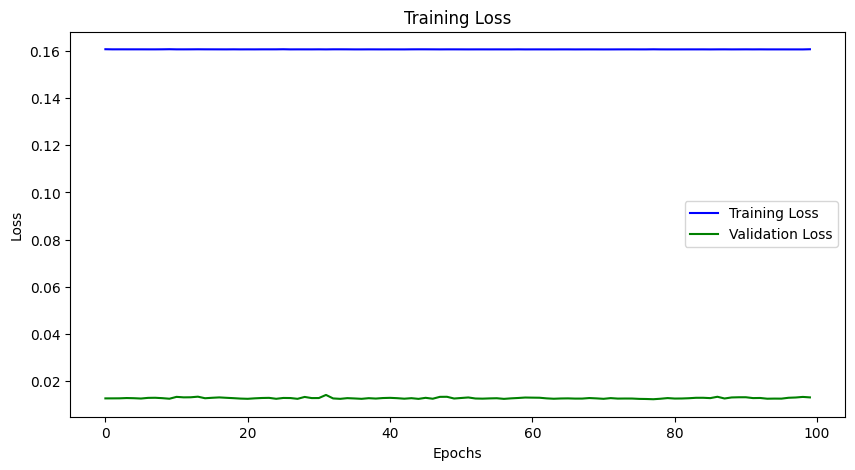

MSELoss on train set
Loss: 0.178594
---------------------------------------------------------------------------

MSELoss on validation set
Loss: 0.032367
---------------------------------------------------------------------------

MSELoss on test set
Loss: 0.244921
---------------------------------------------------------------------------



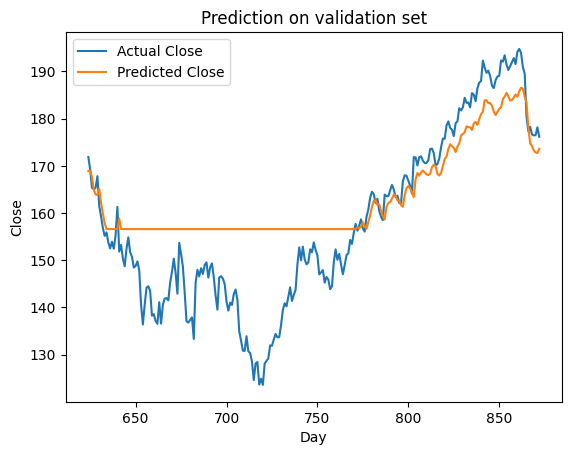

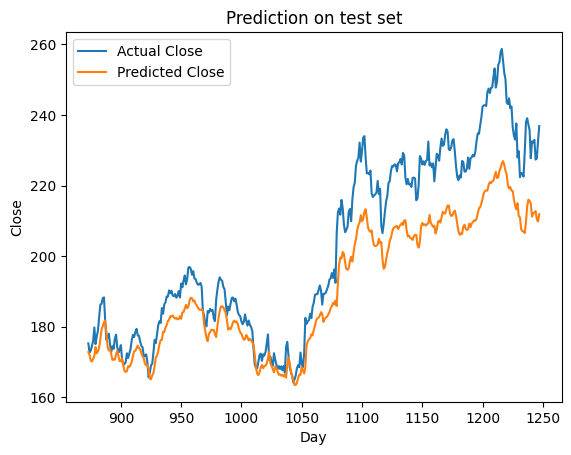

In [32]:
# Ensemble With LSTM and RNN
import torch
import torch.nn as nn
import torch.nn.functional as F

# Define the EnsembleModel class
class EnsembleModel(nn.Module):
    def __init__(self, model, rnn_model ):
        super().__init__()

        self.lstm_model = model
        self.rnn_model = rnn_model
        # self.bilstm_model = bilstm_model

    def forward(self, x):
        lstm_output = self.lstm_model(x)
        rnn_output = self.rnn_model(x)
        # bilstm_output = self.bilstm_model(x)


        # Combine outputs by averaging
        combined_output = ( rnn_output + lstm_output) / 2

        # Apply activation function if needed
        combined_output = F.relu(combined_output)

        return combined_output



# Creating an instance of the EnsembleModel
ensemble_model = EnsembleModel( model,rnn_model )

# Moving the model to the specified device (GPU/CPU)
ensemble_model.to(device)

# Initializing lists to store training and validation losses
train_losses, val_losses = [], []

# Initializing the minimum validation loss to a high value
min_val_loss = 100

# Defining the function to train the model for one epoch
def train_one_epoch(model, train_loader, optimizer, loss_function, epoch):
    # Setting the model to training mode
    model.train(True)

    # Printing the current epoch
    print(f'Epoch: {epoch + 1}')

    # Initializing the running loss for the current epoch
    running_loss = 0.0

    # Iterating through the batches in the training data loader
    for batch_index, batch in enumerate(train_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Forward pass: computing model predictions
        output = model(x_batch)

        # Calculating the loss between model predictions and target labels
        loss = loss_function(output, y_batch)

        # Accumulating the loss
        running_loss += loss.item()

        # Zeroing the gradients
        optimizer.zero_grad()

        # Backward pass: computing gradients
        loss.backward()

        # Updating model parameters
        optimizer.step()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(train_loader)

    # Appending the average training loss to the list of training losses
    train_losses.append(avg_loss_across_batches)

    # Printing the average training loss for the current epoch
    print('Average train loss: {0:.3f}'.format(avg_loss_across_batches))
    print()

# Function to validate the model on the validation set for one epoch
def validate_one_epoch(model, val_loader, min_val_loss, loss_function):
    # Setting the model to evaluation mode (no training)
    model.train(False)
    running_loss = 0.0

    # Iterating through the batches in the loader
    for batch_index, batch in enumerate(val_loader):
        # Extracting input features and target labels from the batch
        x_batch, y_batch = batch[0].to(device), batch[1].to(device)

        # Disabling gradient computation for validation
        with torch.no_grad():
            # Forward pass: computing model predictions
            output = model(x_batch)

            # Calculating the loss between predictions and target labels
            loss = loss_function(output, y_batch)

            # Accumulating the loss
            running_loss += loss.item()

    # Computing the average loss across all batches for the current epoch
    avg_loss_across_batches = running_loss / len(val_loader)

    # Printing the average validation loss for the current epoch
    print('Average valid loss: {0:.6f}'.format(avg_loss_across_batches))

    # Appending the average validation loss to the list of validation losses
    val_losses.append(avg_loss_across_batches)

    # If the current validation loss is lower than the minimum validation loss so far
    if (avg_loss_across_batches < min_val_loss):
        # Update the minimum validation loss
        min_val_loss = avg_loss_across_batches

        # Save the model parameters
        torch.save(model.state_dict(), '/content/Ensemble_model_timeSeries.ckpt')
        print('Saving model...')

    # Printing a separator line for clarity
    print(25 * '---')
    print()

    # Returning the updated minimum validation loss
    return min_val_loss

# Hyperparameters and optimizer configuration
lr = 5e-4
num_epochs = 100
loss_function = nn.MSELoss()
weight_decay = 1e-4
optimizer = torch.optim.Adam(ensemble_model.parameters(), lr=lr, weight_decay=weight_decay)

# Initializing the minimum validation loss to a high value
min_val_loss = float('inf')

# Training loop over epochs
for epoch in range(num_epochs):
    # Training the model for one epoch
    train_one_epoch(ensemble_model, train_loader, optimizer, loss_function, epoch)

    # Validating the model on the validation set for one epoch
    min_val_loss = validate_one_epoch(ensemble_model, val_loader, min_val_loss, loss_function)

# Plotting training loss
plt.figure(figsize=(10, 5))
plt.plot(train_losses, label='Training Loss', color='blue')
plt.plot(val_losses, label='Validation Loss', color='green')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.title('Training Loss')
plt.legend()
plt.show()


# Using torch.no_grad() to temporarily disable gradient calculation, as we're only evaluating the model here
with torch.no_grad():
    # Printing the Mean Squared Error (MSE) loss on the training set
    print('MSELoss on train set')

    # Getting model predictions on the training set and converting them to numpy array on CPU
    train_predictions = ensemble_model(X_train.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the training set
    test_one_epoch(train_loader)

    # Printing the Mean Squared Error (MSE) loss on the validation set
    print('MSELoss on validation set')

    # Getting model predictions on the validation set and converting them to numpy array on CPU
    val_predictions = ensemble_model(X_val.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the validation set
    test_one_epoch(val_loader)

    # Printing the Mean Squared Error (MSE) loss on the test set
    print('MSELoss on test set')

    # Getting model predictions on the test set and converting them to numpy array on CPU
    test_predictions = ensemble_model(X_test.to(device)).to('cpu').numpy()

    # Computing and printing the MSE loss on the test set
    test_one_epoch(test_loader)

# Flattening the train_predictions array
train_predictions = train_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = train_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
train_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_train.shape[0], lookback+1))
dummies[:, 0] = y_train.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_train = dc(dummies[:, 0])

# Flattening the val_predictions array
val_predictions = val_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = val_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
val_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_val.shape[0], lookback+1))
dummies[:, 0] = y_val.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_val = dc(dummies[:, 0])

# Flattening the test_predictions array
test_predictions = test_predictions.flatten()

# Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = test_predictions
dummies = scaler.inverse_transform(dummies)

# Extracting the predicted values after inverse scaling
test_predictions = dc(dummies[:, 0])

# Creating an array of zeros to store actual values, then applying inverse scaling to get original values
dummies = np.zeros((X_test.shape[0], lookback+1))
dummies[:, 0] = y_test.flatten()
dummies = scaler.inverse_transform(dummies)

# Extracting the actual values after inverse scaling
new_y_test = dc(dummies[:, 0])


# Plotting the actual and predicted values for the validation set
plt.plot(val_days, new_y_val, label='Actual Close')
plt.plot(val_days, val_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on validation set')
plt.legend()
plt.show()

# Plotting the actual and predicted values for the test set
plt.plot(test_days, new_y_test, label='Actual Close')
plt.plot(test_days, test_predictions, label='Predicted Close')
plt.xlabel('Day')
plt.ylabel('Close')
plt.title('Prediction on test set')
plt.legend()
plt.show()


# Future Prediction for Next Day

In [33]:
import numpy as np
import torch
import yfinance as yf
from datetime import datetime, timedelta
from copy import deepcopy as dc
from sklearn.preprocessing import MinMaxScaler

# Define the ticker symbol
ticker_symbol = 'AAPL'  # For Reliance use RELIANCE.NS and for TCS use TCS.NS

# Define the start and end dates for the data
end_date = datetime.now()
start_date = end_date - timedelta(days=5*365)  # 5 years ago

# Get the data
df = yf.download(ticker_symbol, start=start_date, end=end_date)

# Reset index to have date as a column
df.reset_index(inplace=True)

# Drop unwanted columns
df = df[['Date', 'Close']]

# # rename 'Close' column to 'Price':
# df.rename(columns={'Close': 'Price'}, inplace=True)

# Selecting columns 'Date' and 'Price' from the dataframe
data = df[['Date', 'Close']]

# Converting the 'Date' column to datetime format
data['Date'] = pd.to_datetime(data['Date'])

df=data

# Function to prepare dataframe for LSTM by adding lagged features
def prepare_dataframe_for_lstm(df, n_steps):
    # Creating a deep copy of the dataframe to avoid modifying the original dataframe
    df = dc(df)

    # Setting the 'Date' column as the index
    df.set_index('Date', inplace=True)

    # Adding lagged features by shifting the 'Close' column backward by n_steps
    for i in range(1, n_steps+1):
        df[f'Close(t-{i})'] = df['Close'].shift(i)

    # Dropping rows with NaN values resulting from the shifting operation
    df.dropna(inplace=True)

    return df

# Number of time steps to look back
lookback = 6

# Creating lagged features
lagged_df = prepare_dataframe_for_lstm(df, lookback)

# Selecting the last row (latest data point) for prediction
last_row = lagged_df.tail(1)

# Removing the last feature (Close price of the most recent day) before scaling
# last_row = last_row.drop(columns=['Close'])

# Extracting the last 7 days' lagged features for prediction
last_7_days_data = last_row.values[0]

# Define your MinMaxScaler instance
scaler = MinMaxScaler(feature_range=(-1, 1))

# Fit and transform the lagged features using MinMaxScaler
scaled_data = scaler.fit_transform(lagged_df.values)

# # Removing the last feature (Close price of the most recent day) after scaling
# scaled_data = scaled_data[:, 1:]

scaled_data=dc(np.flip(scaled_data, axis=1))

def predict_next_day_price(last_7_days_data, rnn_model, scaler):
    # Convert last_7_days_data to numpy array and add a batch dimension
    last_7_days_data = np.array(last_7_days_data).reshape((-1, 7, 1))

    # Convert the scaled data to PyTorch tensor and cast to float
    input_tensor = torch.tensor(last_7_days_data).float()



    # Forward pass through the model to get the prediction
    with torch.no_grad():
        prediction = rnn_model(input_tensor.to(device)).to('cpu').numpy()


    # Flattening the prediction array
    prediction =  prediction.flatten()


    # Creating an array of zeros to store predictions and actual values, then applying inverse scaling to get original values
    dummies = np.zeros((input_tensor.shape[0], lookback+1))
    dummies[:, 0] = prediction
    dummies = scaler.inverse_transform(dummies)

    # Extracting the predicted values after inverse scaling
    next_day_price = dc(dummies[:, 0])/2

    return next_day_price


# Predict the next day's price
next_day_prediction = predict_next_day_price(last_7_days_data, rnn_model, scaler)
print()

print("Predicted price for the next day:", next_day_prediction)


[*********************100%***********************]  1 of 1 completed


Predicted price for the next day: [214.54261499]
